In [1]:
import pandas as pd
import utils

In [55]:
# Load this data, which contains a currated collection of features from ADNI
df = pd.read_csv('../data/adni/ADNIMERGE.csv')
df['Visit_Month'] = df['VISCODE'].apply(lambda x: utils.dictVisit2Months[x])

In [74]:
# Limit to ADNI 1
dfADNI1 = df.loc[df['COLPROT'] == 'ADNI1']
dfADNI1.index = pd.MultiIndex.from_frame(dfADNI1[['PTID', 'Visit_Month']])
dfADNI1 = dfADNI1.sort_index()
# Fill in missing diagnoses, IF the diagnoses at the preceding and subsequent visits are the same
dfADNI1['DX'].loc[dfADNI1['DX'].shift(-1) == dfADNI1['DX'].shift(1)] = dfADNI1['DX'].shift(1)

print(dfADNI1.shape[0], 'samples in ADNI1')
# Limit to subjects with MCI
dfMCI = dfADNI1.loc[dfADNI1['DX'] == 'MCI']
dfMCI.index = pd.MultiIndex.from_frame(dfMCI[['PTID', 'Visit_Month']])
print(dfMCI.shape[0], 'samples with MCI')


5013 samples in ADNI1
1804 samples with MCI


In [81]:
# For each sample, check for conversion to AD at various timepoints
subjects = dfMCI['PTID'].unique()
subjects.sort()
print(subjects.shape[0], 'unique subjects with MCI at baseline')
dfConversion = pd.DataFrame(index=dfMCI.index)

for nMonths in [6, 12, 18, 24, 30, 36, 42, 48]:
    lsConversion = []
    for strID, nVisit in dfConversion.index:
        if (strID, nVisit + nMonths) in dfADNI1.index:
            # check if DX is available at exactly this time interval
            lsConversion += [dfADNI1['DX'].loc[(strID, nVisit + nMonths)] == 'Dementia']
        else:
            # Check the nearest visits before and after this timepoint
            dfVisits = dfADNI1['DX'].loc[strID]
            dfVisits = dfVisits.sort_index()
            dfNextVisits = dfVisits.loc[dfVisits.index > (nVisit + nMonths)]
            dfPrevVisits = dfVisits.loc[dfVisits.index < (nVisit + nMonths)]
            if dfPrevVisits.shape[0] > 0:
                # If they had already converted, mark as converted at this timepoint
                if dfPrevVisits.iloc[-1] == 'Dementia':
                    lsConversion += [True]
                    continue
                # Otherwise, check future visits
            if dfNextVisits.shape[0] > 0:
                # If they haven't converted in the next visit, mark as non-converted
                if dfNextVisits.iloc[0] != 'Dementia':
                    lsConversion += [False]
                    continue
                # Otherwise, conversion status is unknown
            lsConversion += ['unknown']

    dfConversion[nMonths] = lsConversion


409 unique subjects with MCI at baseline


In [94]:
# Make sure that when conversion occurs, it is propagated across all subsequent timepoints. There may be some NaN values remaining that cause a False to appear after someone has already converted at a previous timepoint.
for idx, row in dfConversion.iterrows():
    if True in row.values:
        lastTrue = row.index[row == True].values[-1]
        row.loc[row.index > lastTrue] = True

# Drop rows with all unknowns
dfConversion = dfConversion.loc[~(dfConversion == 'unknown').all(axis=1)]
print(dfConversion.shape[0], 'samples with conversion status available at any timepoint')



1606 samples with conversion status available at any timepoint


In [95]:
dfConversion.iloc[180:210]

6        12       18       24       30       36  \
PTID       Visit_Month                                                       
012_S_1292 0             True     True     True     True     True     True   
012_S_1321 0            False    False    False    False  unknown  unknown   
           6            False    False    False  unknown  unknown  unknown   
           12           False    False  unknown  unknown  unknown  unknown   
           18           False  unknown  unknown  unknown  unknown  unknown   
013_S_0240 0            False    False     True     True     True     True   
           6            False     True     True     True     True     True   
           12            True     True     True     True     True     True   
013_S_0325 0            False    False     True     True     True     True   
           6            False     True     True     True     True     True   
           12            True     True     True     True     True     True   
013_S_0860 0            False     True     True     True     True     True   
           6             True     True     True     True     True     True   
013_S_1120 0            False    False    False    False    False  unknown   
           6            False    False    False    False  unknown  unknown   
           12           False    False    False  unknown  unknown  unknown   
           18           False    False  unknown  unknown  unknown  unknown   
           24           False  unknown  unknown  unknown  unknown  unknown   
013_S_1186 0            False    False    False    False  unknown  unknown   
           6            False    False    False  unknown  unknown  unknown   
           12           False    False  unknown  unknown  unknown  unknown   
           18           False  unknown  unknown  unknown  unknown  unknown   
013_S_1275 0            False    False    False  unknown  unknown  unknown   
           6            False    False  unknown  unknown  unknown  unknown   
           12           False  unknown  unknown  unknown  unknown  unknown   
014_S_0169 0            False    False    False    False    False    False   
           6            False    False    False    False    False    False   
           12           False    False    False    False    False    False   
           18           False    False    False    False    False  unknown   
           24           False    False    False    False  unknown  unknown   

                             42       48  
PTID       Visit_Month                    
012_S_1292 0               True     True  
012_S_1321 0            unknown  unknown  
           6            unknown  unknown  
           12           unknown  unknown  
           18           unknown  unknown  
013_S_0240 0               True     True  
           6               True     True  
           12              True     True  
013_S_0325 0               True     True  
           6               True     True  
           12              True     True  
013_S_0860 0               True     True  
           6               True     True  
013_S_1120 0            unknown  unknown  
           6            unknown  unknown  
           12           unknown  unknown  
           18           unknown  unknown  
           24           unknown  unknown  
013_S_1186 0            unknown  unknown  
           6            unknown  unknown  
           12           unknown  unknown  
           18           unknown  unknown  
013_S_1275 0            unknown  unknown  
           6            unknown  unknown  
           12           unknown  unknown  
014_S_0169 0              False    False  
           6              False  unknown  
           12           unknown  unknown  
           18           unknown  unknown  
           24           unknown  unknown

Text(0, 0.5, 'Count')

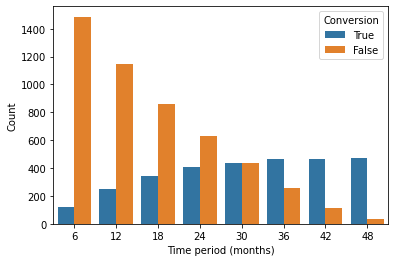

In [101]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
dfLong = dfConversion.melt(var_name='Time period (months)', value_name='Conversion')
sns.countplot(data=dfLong, x='Time period (months)', hue='Conversion', hue_order=[True, False])
plt.ylabel('Count')


In [102]:
# Save data to file
dfConversion.to_csv('conversion_by_month.csv')
dfADNI1.loc[dfConversion.index].to_csv('adnimerge_mci.csv')